# Imports

In [1]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
nproc = min([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo


randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker="s") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color="red",marker="s")     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="black") #,alpha=0.2
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel(label+" measured",fontsize=20)
    plt.ylabel(label+" predicted",fontsize=20)
    plt.tight_layout()
    
#     plt.xticks([])
#     plt.yticks([])
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)


In [2]:
def plot_fit_label(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker="s") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color="red",marker="s")     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="black") #,alpha=0.2
    
    #Create list of tuples for y pred and y all
    y_labels_test = y_labels[VS]
    for (x,y,name) in zip(list(y_test),list(y_pred_test),list(y_labels_test)):
        plt.text(x,y,name)
    
    model_df = {'y_labels'}
    
    if leg:
        plt.legend(loc='lower right')
    
    #if label_all:
    #    plt.text(y_train,y_pred_train,y_labels[TS])
    #    plt.text(y_test,y_pred_test,y_labels[VS])
    plt.xlabel(label+" measured",fontsize=20)
    plt.ylabel(label+" predicted",fontsize=20)
    plt.tight_layout()
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)

# Reading data

## Single File

In [3]:
# all data in a single file
#excel_file = "OPR3_NS5B_MMFF_mm_min_geom"
excel_file = "OPLS3E_OPR3_NS5B_ALL_jme_updated"
excel_sheet = "full_parameter_csv"
num_par = 188
par_start_col = 3 # 0-indexed
num_samples = 30
response_col = 1 # 0-indexed
y_label_col = 0 # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True

inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=max(y_label_col,response_col,num_par+par_start_col)-1)
if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1])
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

n_samples before removing empty cells: 30
Removing 0 samples.
Shape X: (30, 188)
Shape y: (30,)
Shape labels: (30,)
First X cell: 1.43670729322534
Last X cell:  19.36
First y: 0.20474563307111318
Last y:  0.01501960242813733
Last label: TFP


## Separate Files

In [ ]:
## separate files for exp data and comp data

comp_file = "Phosphine_library_DFT_props_190517"
comp_sheet = "selprops_n_only"
num_par = 135
par_start_col = 1 # 0-indexed
comp_num_samples = 1198
y_label_col_comp = 0 # 0-indexed

exp_file = "Phosphine_library_explitdata"
exp_sheet = "LibraryGTZ"
exp_num_samples = 1282
response_col = 7 # 0-indexed
y_label_col_exp = 1 # 0-indexed

compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,
                        nrows=comp_num_samples+1,usecols=num_par+par_start_col-1)
compinp.index = compinp.index.map(str)
expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=4,index_col=y_label_col_exp,
                       nrows=exp_num_samples,usecols=response_col)
expinp.index = [i.zfill(4) for i in expinp.index.map(str)]

xlabelrow = True
verbose = True

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))

resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X
print("n_samples before removing empty cells: {}".format(len(y)))
print("Removing {} samples.".format(len(y)-sum(mask)))
y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]

X = np.asarray(compinp.loc[y_labels],dtype=np.float)

if verbose:
    print("Shape X (all): {}".format(X_all.shape))
    print("Shape X (exp): {}".format(X.shape))
    print("Shape y (exp): {}".format(y.shape)) 
    print("Shape labels (exp): {}".format(y_labels.shape)) 
    print("First X (exp) cell: {}".format(X[0,0]))
    print("Last X (exp) cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label exp: {}".format(y_labels[-1]))
    print("Last label comp: {}".format(y_labels_comp[-3:]))
    #print(inp.head())

# Basic visualization

 ## Histograms and univariate correlations

x1 Dipole_Boltz


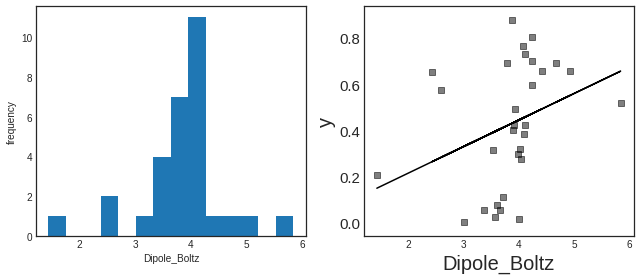

R^2 = 0.11; p-value = 0.07

-------------------------------------------------------------------------------

x2 EFG_Amplitude_Boltz


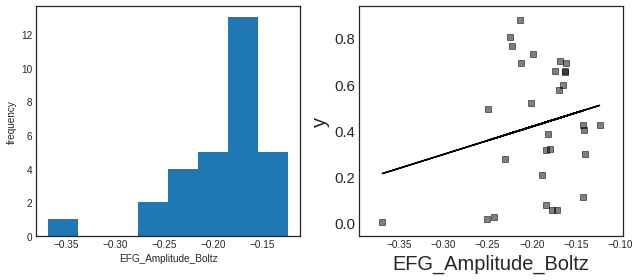

R^2 = 0.05; p-value = 0.26

-------------------------------------------------------------------------------

x3 EFG_XX_Boltz


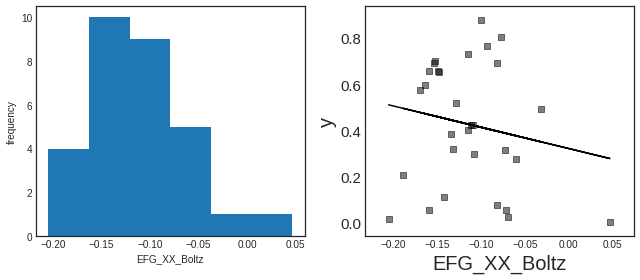

R^2 = 0.03; p-value = 0.36

-------------------------------------------------------------------------------

x4 EFG_YY_Boltz


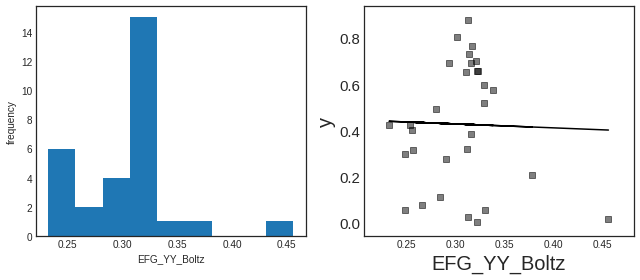

R^2 = 0.00; p-value = 0.89

-------------------------------------------------------------------------------

x5 EFG_ZZ_Boltz


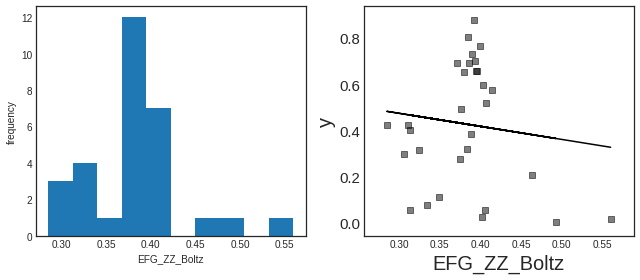

R^2 = 0.01; p-value = 0.54

-------------------------------------------------------------------------------

x6 fukui+_Boltz


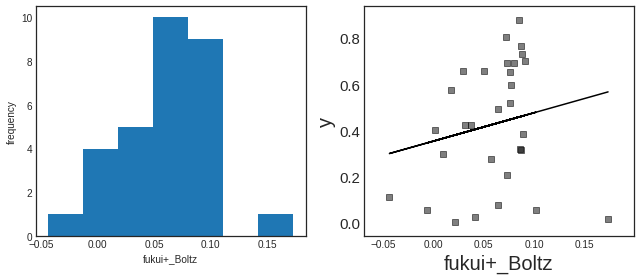

R^2 = 0.03; p-value = 0.32

-------------------------------------------------------------------------------

x7 fukui-_Boltz


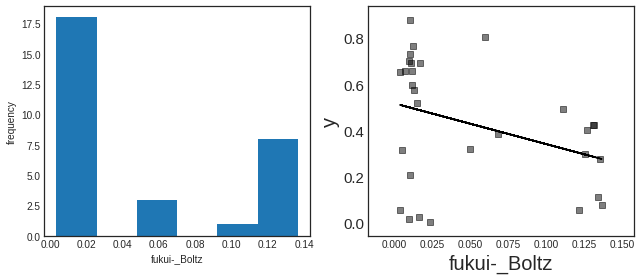

R^2 = 0.12; p-value = 0.06

-------------------------------------------------------------------------------

x8 EHOMO_Boltz


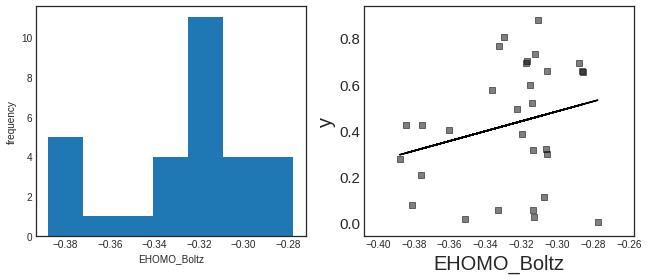

R^2 = 0.06; p-value = 0.20

-------------------------------------------------------------------------------

x9 ELUMO_Boltz


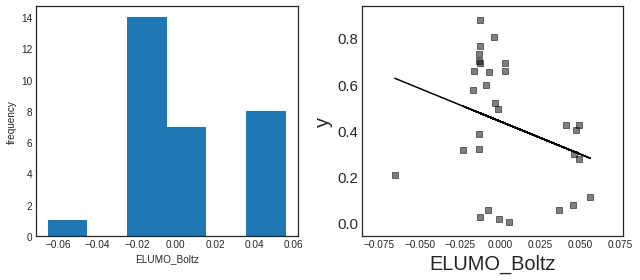

R^2 = 0.09; p-value = 0.10

-------------------------------------------------------------------------------

x10 mu_Boltz


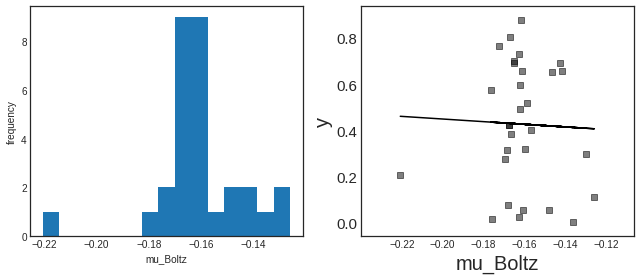

R^2 = 0.00; p-value = 0.85

-------------------------------------------------------------------------------

x11 eta_Boltz


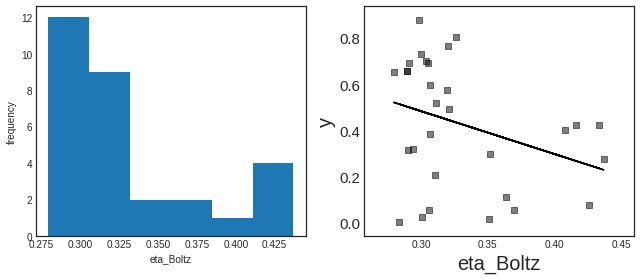

R^2 = 0.11; p-value = 0.07

-------------------------------------------------------------------------------

x12 omega_Boltz


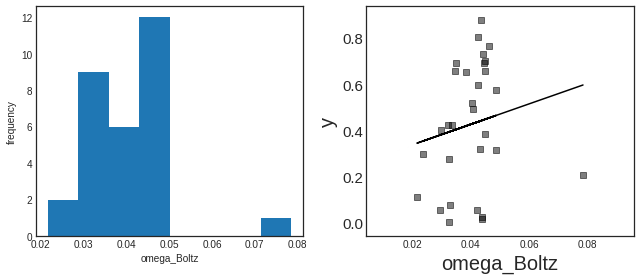

R^2 = 0.03; p-value = 0.38

-------------------------------------------------------------------------------

x13 EP_O_Boltz


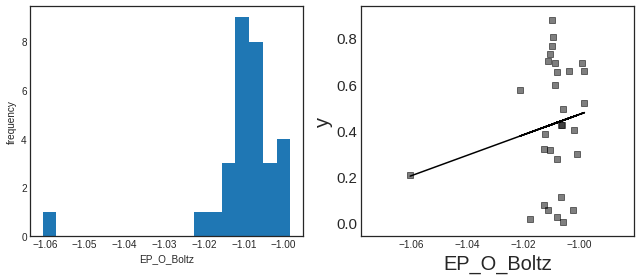

R^2 = 0.03; p-value = 0.34

-------------------------------------------------------------------------------

x14 natural_charge_P_Boltz


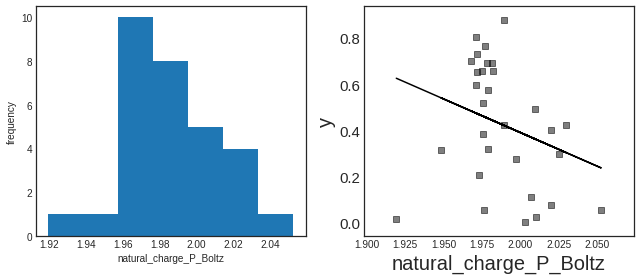

R^2 = 0.08; p-value = 0.13

-------------------------------------------------------------------------------

x15  EP_Cantibonds_avg_Boltz


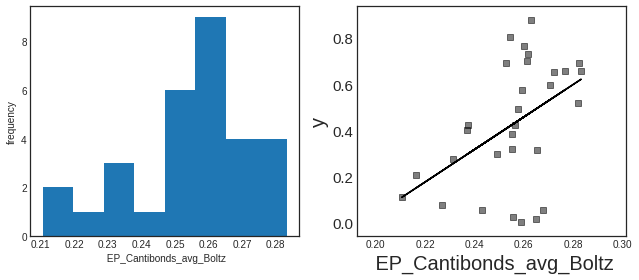

R^2 = 0.22; p-value = 8.51E-03

-------------------------------------------------------------------------------

x16  EP_Cbonds_avg_Boltz


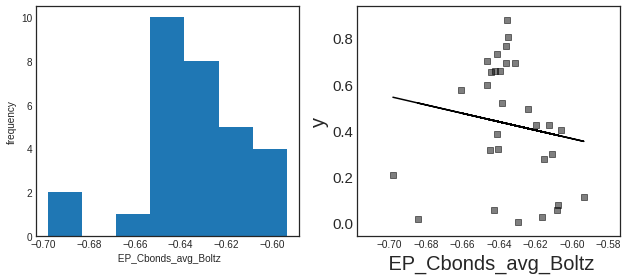

R^2 = 0.02; p-value = 0.43

-------------------------------------------------------------------------------

x17 E_Prydberg_min_Boltz


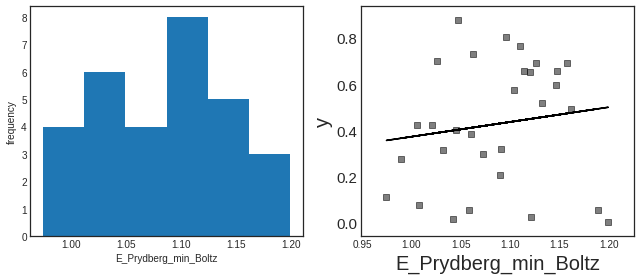

R^2 = 0.02; p-value = 0.46

-------------------------------------------------------------------------------

x18 percent_s_charP_Boltz


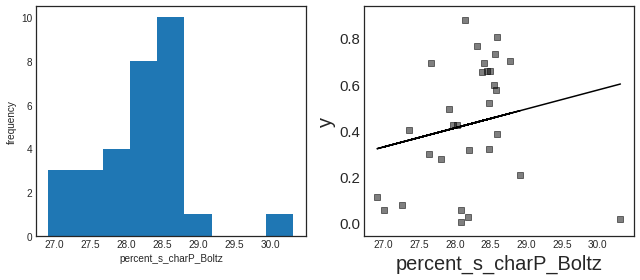

R^2 = 0.04; p-value = 0.30

-------------------------------------------------------------------------------

x19 Hirshfeld_dipole_P_Boltz


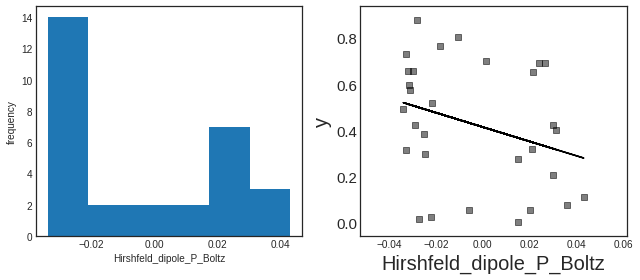

R^2 = 0.09; p-value = 0.10

-------------------------------------------------------------------------------

x20 Hirshfeld_chargeP_Boltz


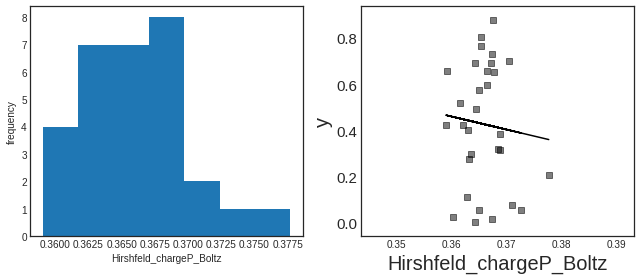

R^2 = 0.01; p-value = 0.66

-------------------------------------------------------------------------------

x21 CM5_chargeP_Boltz


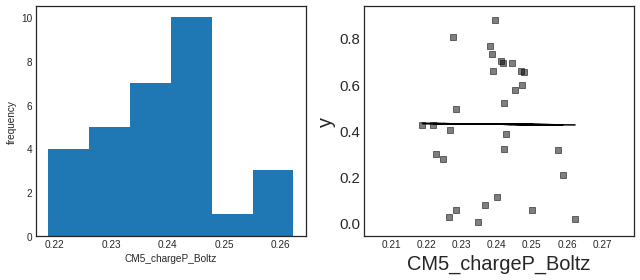

R^2 = 0.00; p-value = 0.97

-------------------------------------------------------------------------------

x22 P_Isotropic_Shift_Boltz


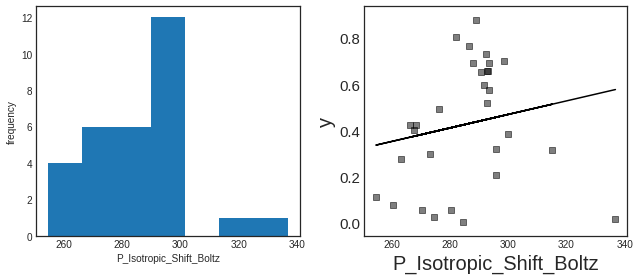

R^2 = 0.03; p-value = 0.34

-------------------------------------------------------------------------------

x23 P_Anisotropic_Eigenval_XX_Boltz


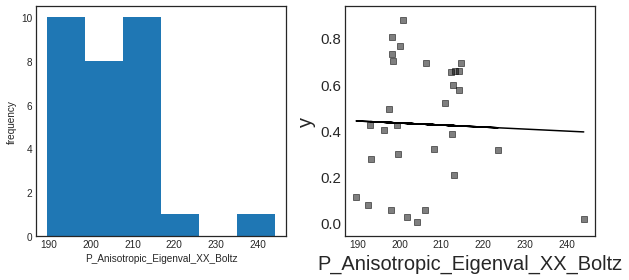

R^2 = 0.00; p-value = 0.85

-------------------------------------------------------------------------------

x24 P_Anisotropic_Eigenval_YY_Boltz


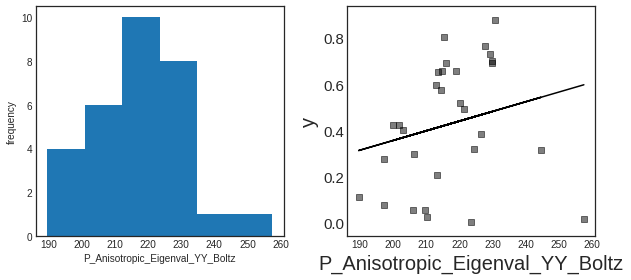

R^2 = 0.05; p-value = 0.23

-------------------------------------------------------------------------------

x25 P_Anisotropic_Eigenval_ZZ_Boltz


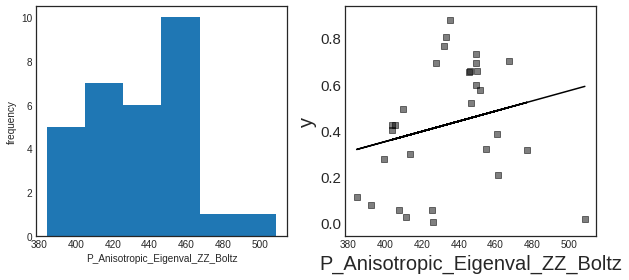

R^2 = 0.05; p-value = 0.23

-------------------------------------------------------------------------------

x26 Polarizability_Boltz


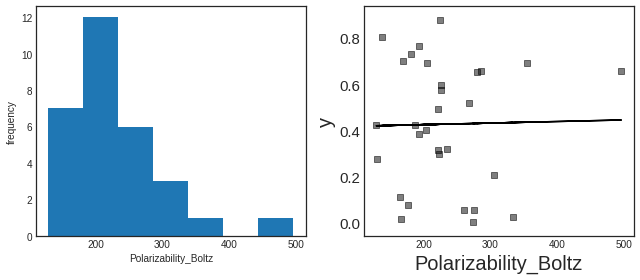

R^2 = 0.00; p-value = 0.92

-------------------------------------------------------------------------------

x27 Amplitude_Boltz


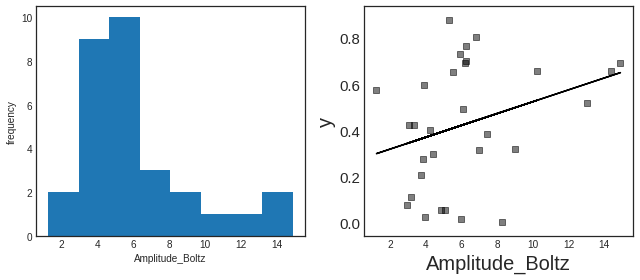

R^2 = 0.10; p-value = 0.09

-------------------------------------------------------------------------------

x28 EigXX_Boltz


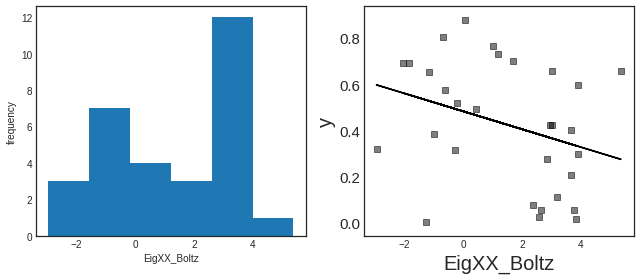

R^2 = 0.10; p-value = 0.08

-------------------------------------------------------------------------------

x29 EigYY_Boltz


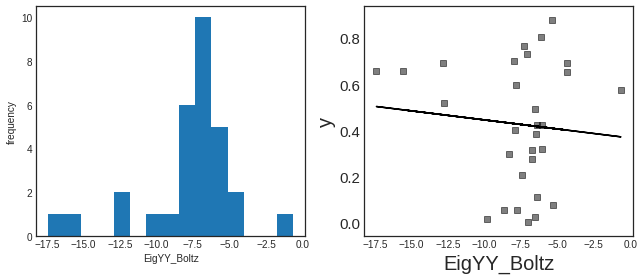

R^2 = 0.01; p-value = 0.61

-------------------------------------------------------------------------------

x30 EigZZ_Boltz


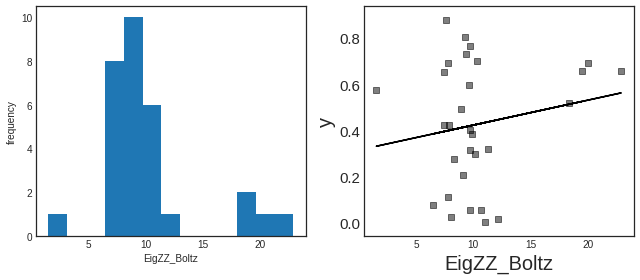

R^2 = 0.03; p-value = 0.35

-------------------------------------------------------------------------------

x31 %Vbur_Boltz


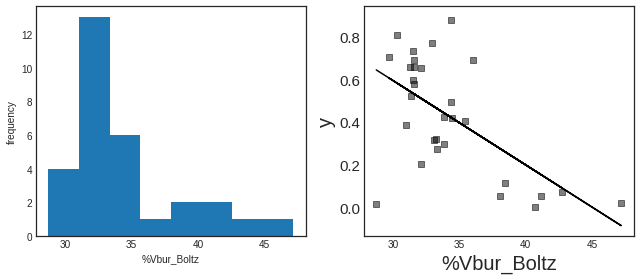

R^2 = 0.37; p-value = 3.31E-04

-------------------------------------------------------------------------------

x32 %Vbur(SW)_Boltz


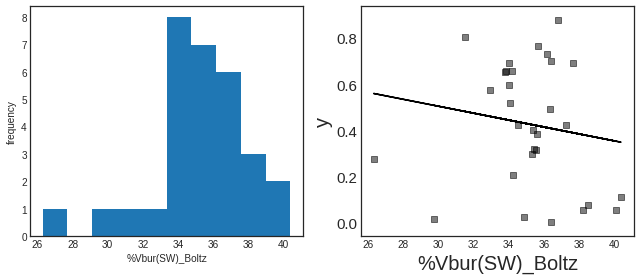

R^2 = 0.02; p-value = 0.41

-------------------------------------------------------------------------------

x33 %Vbur(NW)_Boltz


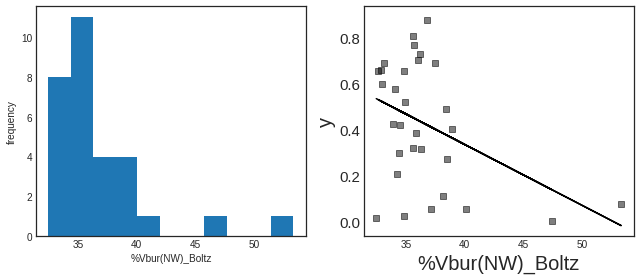

R^2 = 0.18; p-value = 0.02

-------------------------------------------------------------------------------

x34 %Vbur(NE)_Boltz


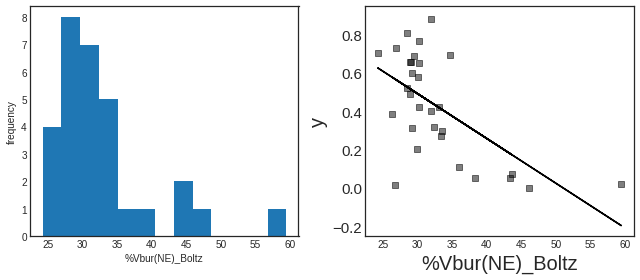

R^2 = 0.38; p-value = 2.60E-04

-------------------------------------------------------------------------------

x35 %Vbur(SE)_Boltz


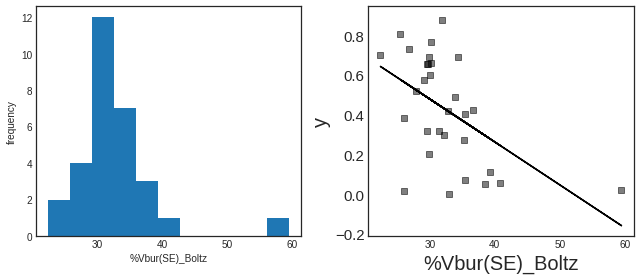

R^2 = 0.28; p-value = 2.60E-03

-------------------------------------------------------------------------------

x36 %Vbur(min Quadrant)_Boltz


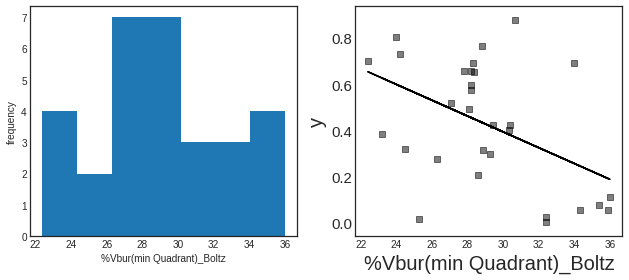

R^2 = 0.22; p-value = 8.95E-03

-------------------------------------------------------------------------------

x37 %Vbur(max Quadrant)_Boltz


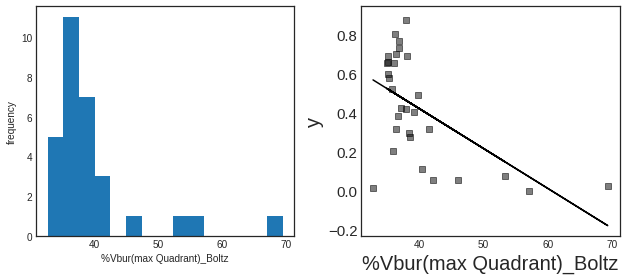

R^2 = 0.33; p-value = 8.56E-04

-------------------------------------------------------------------------------

x38 (max-min Quadrant)/%Vbur(total)_Boltz


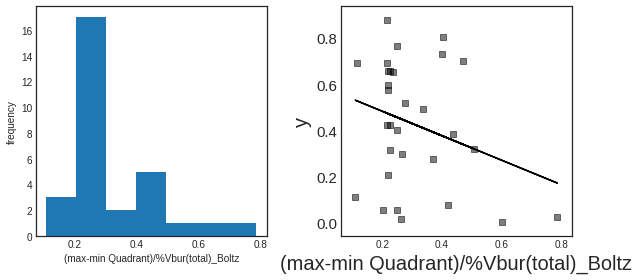

R^2 = 0.08; p-value = 0.13

-------------------------------------------------------------------------------

x39 L_Boltz


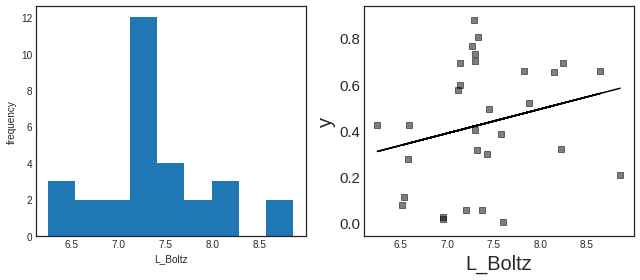

R^2 = 0.06; p-value = 0.20

-------------------------------------------------------------------------------

x40 B1_Boltz


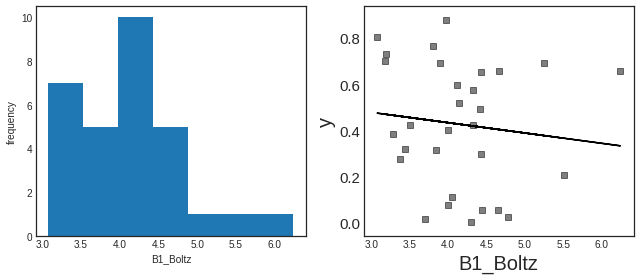

R^2 = 0.01; p-value = 0.54

-------------------------------------------------------------------------------

x41 B5_Boltz


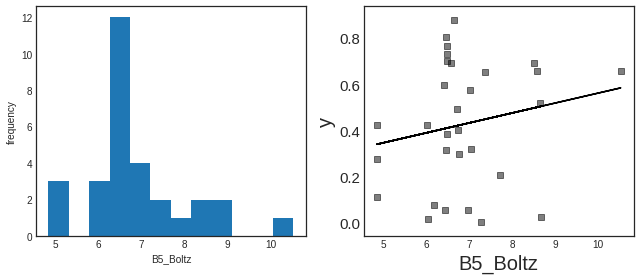

R^2 = 0.04; p-value = 0.31

-------------------------------------------------------------------------------

x42 BuriedB1_Boltz


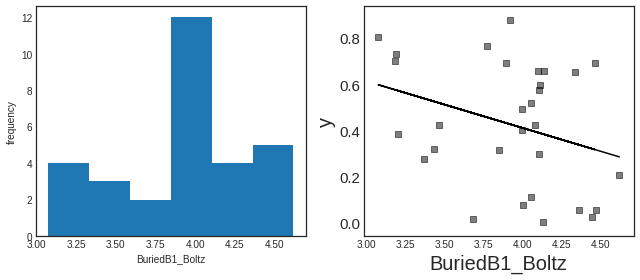

R^2 = 0.10; p-value = 0.09

-------------------------------------------------------------------------------

x43 BuriedB5_Boltz


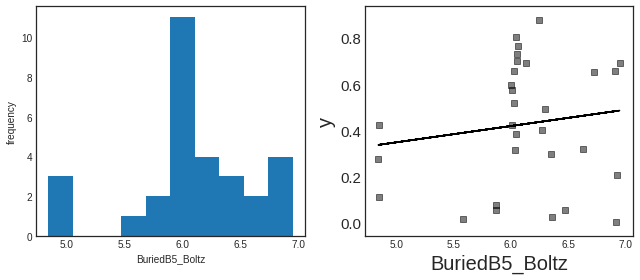

R^2 = 0.02; p-value = 0.45

-------------------------------------------------------------------------------

x44 vmin_Boltz


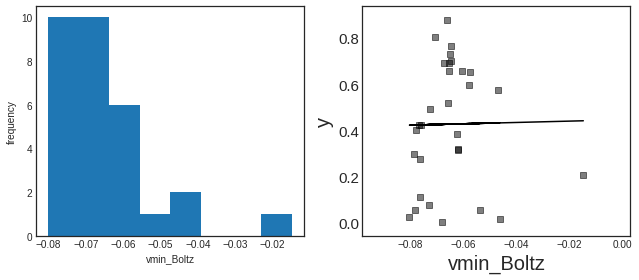

R^2 = 0.00; p-value = 0.94

-------------------------------------------------------------------------------

x45 rmin_Boltz


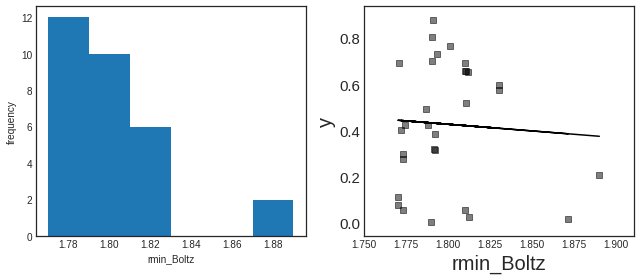

R^2 = 0.00; p-value = 0.75

-------------------------------------------------------------------------------

x46 ECA_Boltz


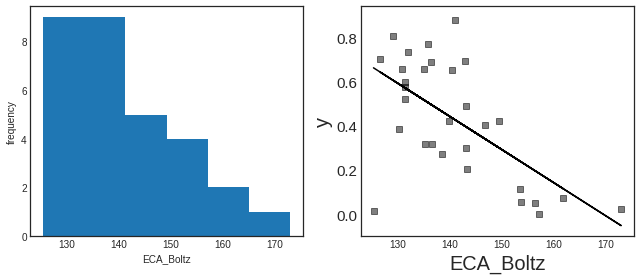

R^2 = 0.39; p-value = 2.19E-04

-------------------------------------------------------------------------------

x47 G_Pd_Boltz


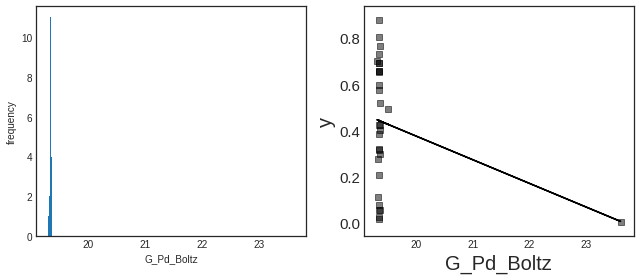

R^2 = 0.09; p-value = 0.11

-------------------------------------------------------------------------------



In [4]:
# Visualize Histograms and univariate correlations for all (or selected) features
#features = range(np.shape(X)[1])   # iterate over all features
# examples for selecting features
#specify names:
# features = [x_names.index("sterimol_5-.5cB5_max")]
#specify x-numbers (1-indexed):
#features_x = ["x44","x89","x134","x179"]
#features = [x_labels.index(i) for i in features_x]
#specify ranges (0-indexed)
# features = itertools.chain(range(75,85),range(90,95))
features = itertools.chain(range(0,47))
#features = [30,45]

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    
    plt.figure(figsize=(9, 4))
    plt.style.use('seaborn-white')
    plt.subplot(1,2,1)
    plt.hist(X[:,f_ind], bins="auto")
    plt.ylabel("frequency")
    plt.xlabel(X_names[f_ind])
    
    plt.subplot(1,2,2)
    plt.scatter(X[:,f_ind], y,color="black",marker="s",alpha=0.5)    
    plt.plot(X[:,f_ind],fit_line,color="black")
    plt.xlabel(X_names[f_ind],fontsize=20)
    plt.ylabel("y",fontsize=20)

#     plt.xticks(np.arange(round(min(X[:,f_ind])-0.005,3), round(max(X[:,f_ind])+0.005,3), 0.03),fontsize=15)
    plt.yticks(fontsize=15)        
    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")
    
  

x31 %Vbur_Boltz
R^2 = 0.37; p-value = 3.31E-04

-------------------------------------------------------------------------------



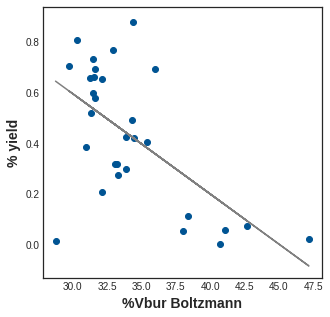

In [5]:
features = [30]

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    plt.style.use('seaborn-white')
    plt.figure(figsize=(5, 5))
    
    plt.scatter(X[:,f_ind], y,color="#005493",marker="o")    
    plt.plot(X[:,f_ind],fit_line,color="grey")
    plt.xlabel("%Vbur Boltzmann",fontsize=14,fontweight="bold")
    plt.ylabel("% yield",fontsize=14,fontweight="bold")

#     plt.xticks(np.arange(round(min(X[:,f_ind])-0.005,3), round(max(X[:,f_ind])+0.005,3), 0.03),fontsize=15)
           
    #plt.tight_layout()
    #plt.show() 
    plt.savefig(str(feature+excel_file))

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")
    
  

## plot a feature vs. another feature

x20 Hirshfeld_chargeP_Boltz
x31 %Vbur_Boltz

30 samples
R^2 = 0.01; p-value = 6.15E-01


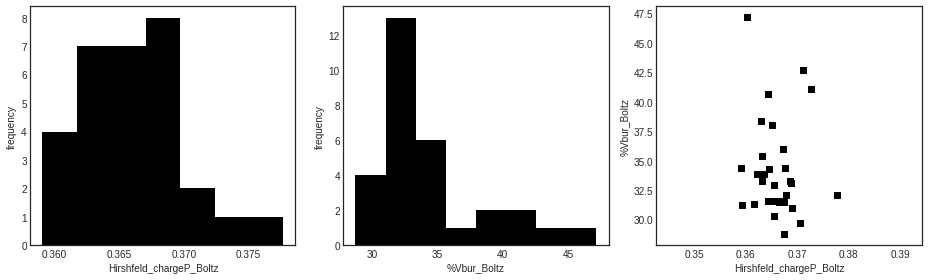

In [6]:
#select two features to visualize
# can be integer-index of features, or string with x-number
f_ind_1 = "x20"
f_ind_2 = "x31"

if type(f_ind_1) == str:
    [f_ind_1,f_ind_2] = [X_labels.index(i) for i in [f_ind_1,f_ind_2]]

print(X_labels[f_ind_1], X_names[f_ind_1])
print(X_labels[f_ind_2], X_names[f_ind_2])
print("\n{} samples".format(np.shape(X[:,f_ind_1])[0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind_1],X[:,f_ind_2])
fit_line = intercept+slope*X[:,f_ind_1]
print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.hist(X[:,f_ind_1], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_1])
plt.subplot(1,3,2)
plt.hist(X[:,f_ind_2], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_2])

plt.subplot(1,3,3)
plt.scatter(X[:,f_ind_1], X[:,f_ind_2],color="black",marker="s")    
#plt.plot(X[:,f_ind_1],fit_line)
plt.xlabel(X_names[f_ind_1])
plt.ylabel(X_names[f_ind_2])
plt.tight_layout()
plt.show()    

## Correlation Map

<IPython.core.display.Javascript object>


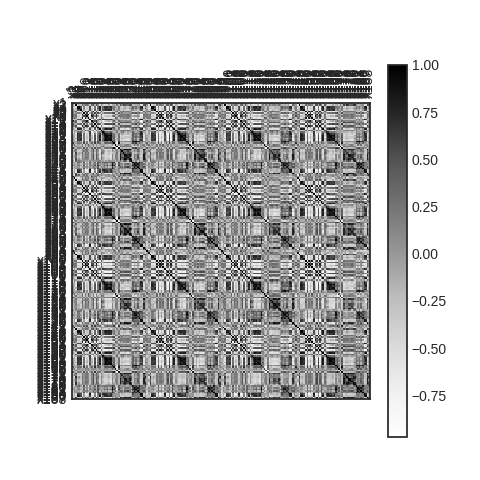

In [7]:
%matplotlib notebook
# this will open an interactive plot that you can enlarge and zoom into

corrmap = np.corrcoef(X.T)
plt.matshow(corrmap)
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

## Seaborn Correlation Map

<IPython.core.display.Javascript object>


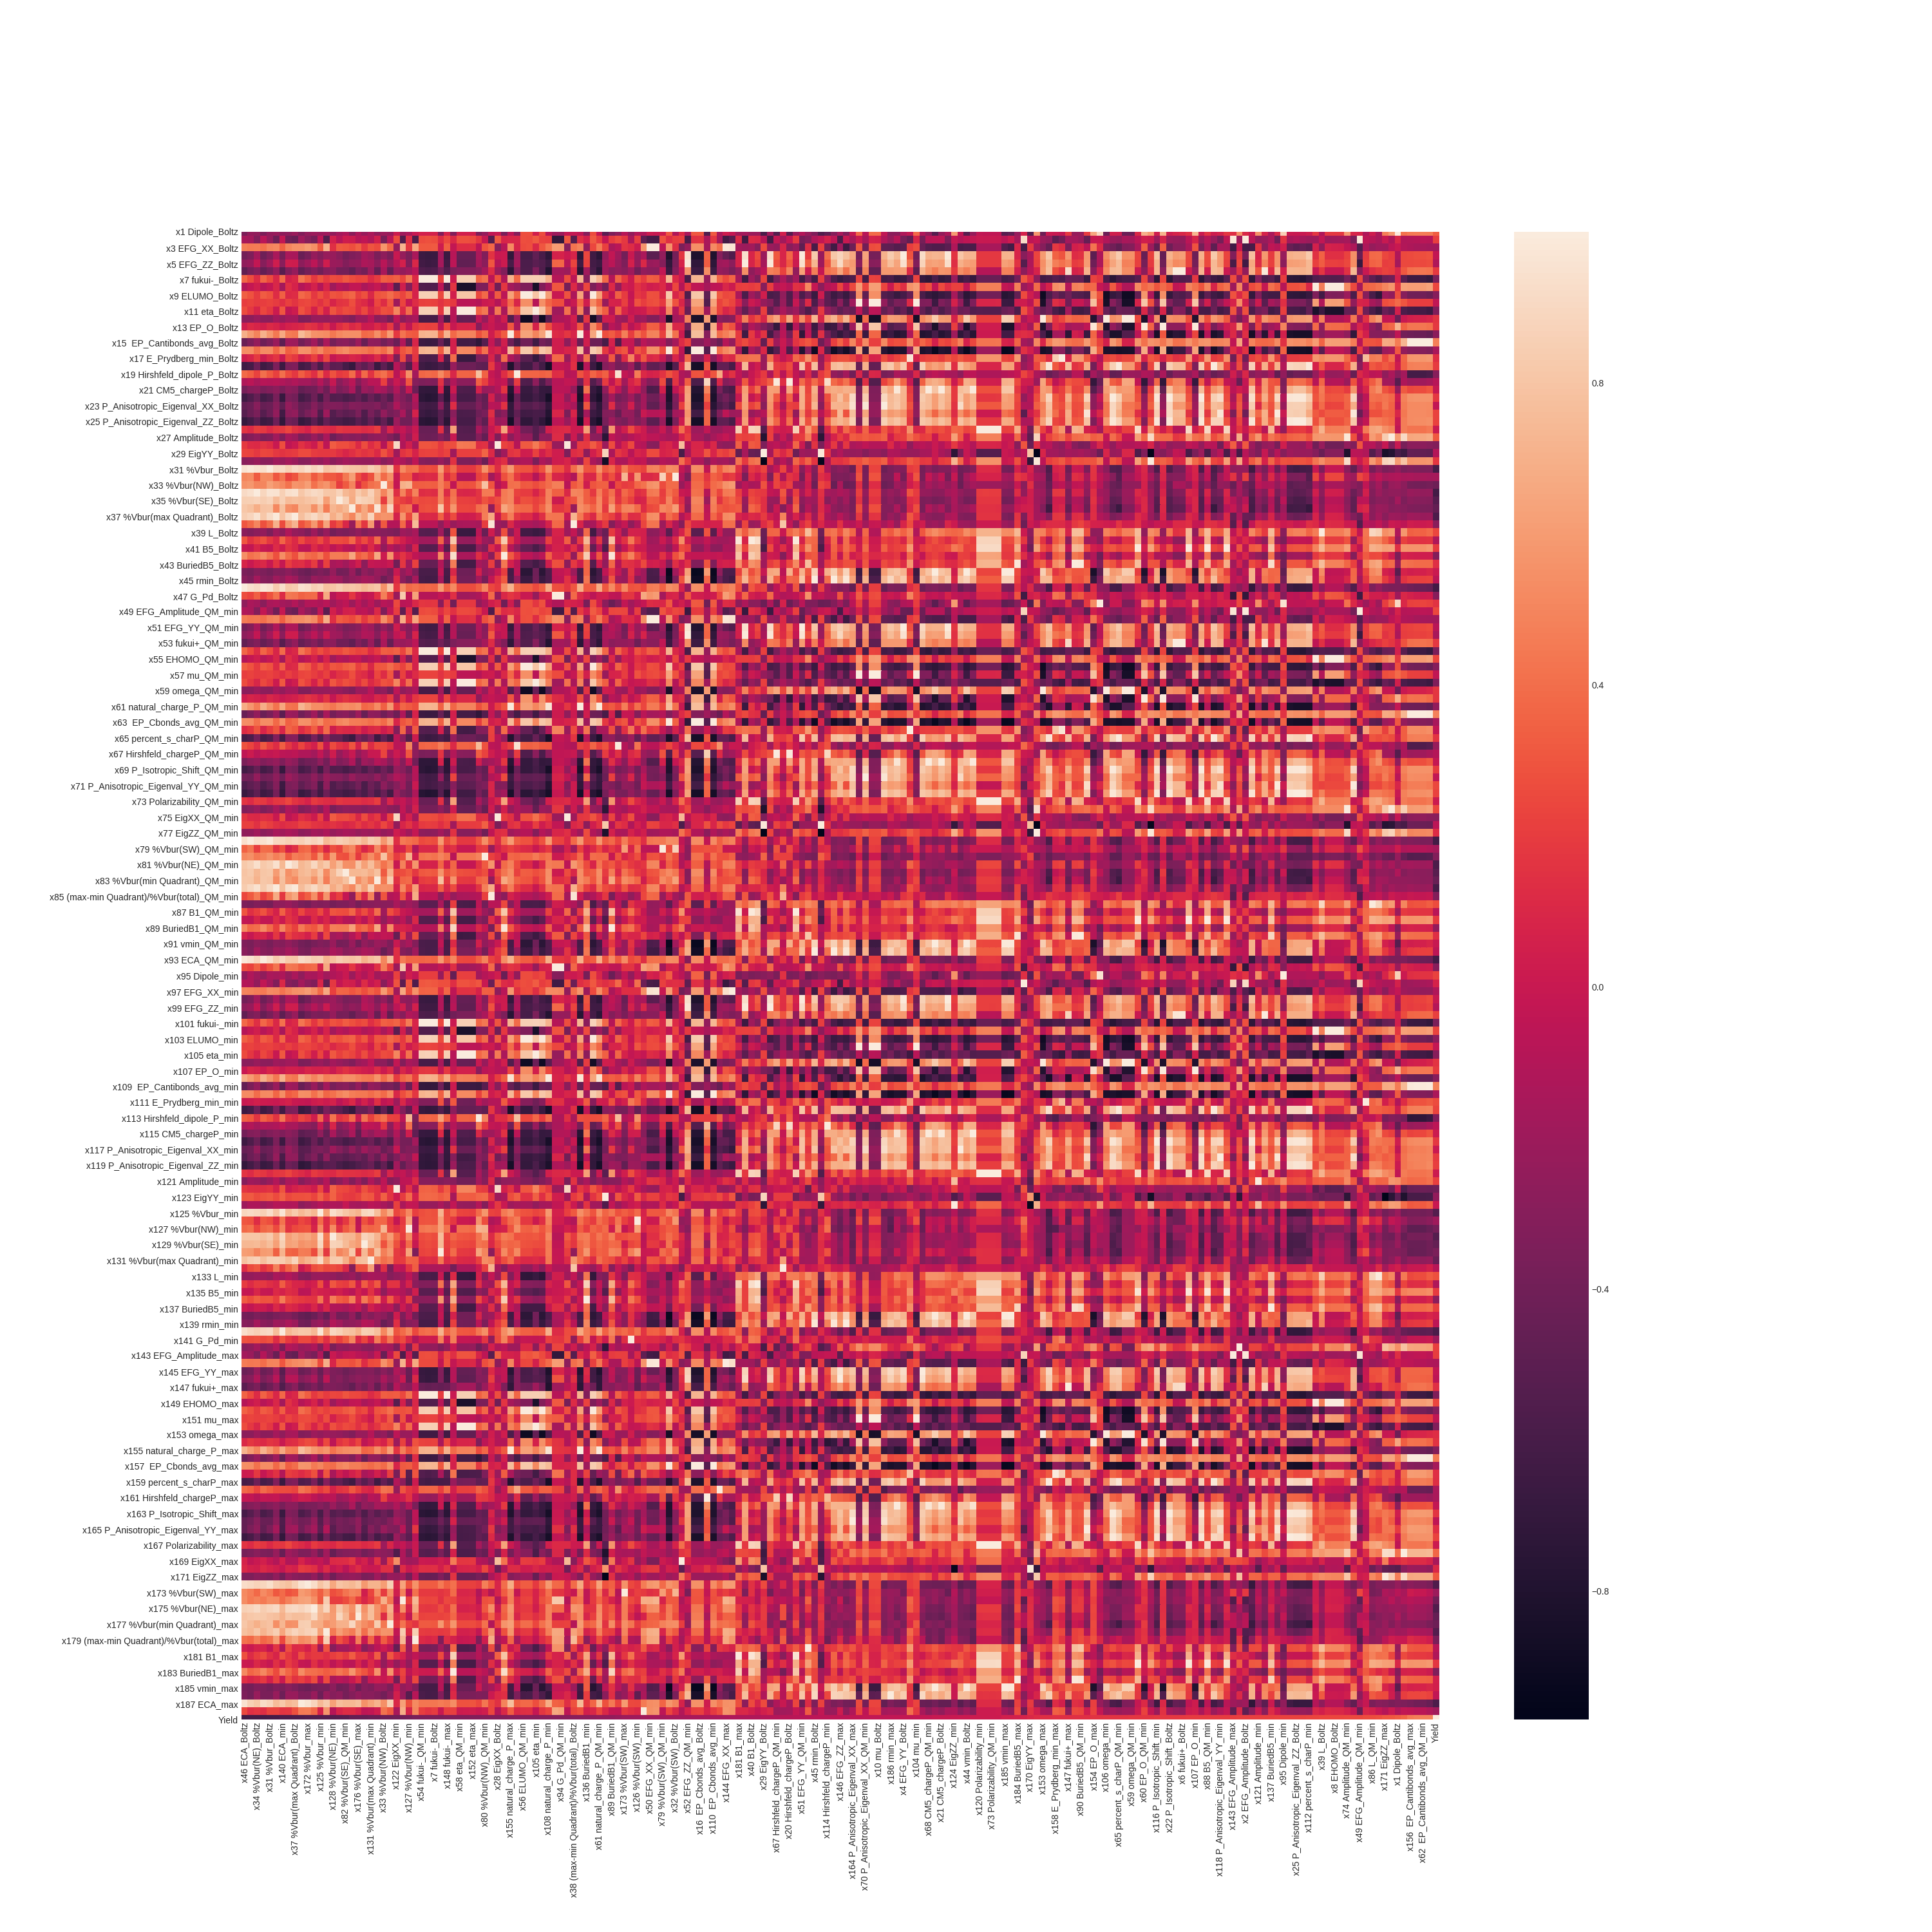

In [8]:
%matplotlib notebook

#Create Seaborn heatmap sorted according to correlation to response
#Choose selection of features? - Create pandas df! Then relate to y + sort according to correlation to y 
#df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
sns.set_style()
fig, ax = plt.subplots(figsize=(30,30))

parameters = pd.DataFrame(X,index=list(y_labels),columns=list(X_labelname))
y_df = pd.DataFrame(y,index=list(y_labels))
y_response = [resp_label]
y_df.columns = y_response
full_df = pd.concat([parameters,y_df],axis=1)

#sns.heatmap(full_df)

Xy_labelname = [" ".join(i) for i in zip(X_labels,X_names)]
Xy_labelname.append(resp_label)

Xy = np.hstack((X,y[:,None]))
corrmap = np.corrcoef(Xy.T)
corrmap_df = pd.DataFrame(corrmap,index=Xy_labelname,columns=Xy_labelname)
corrmap_df_resp_sorted = corrmap_df.sort_values(by='Yield')
corrmap_df_resp_sorted = corrmap_df.sort_values(by='Yield',axis=1)
#Create labeled df and then sort according to correlation with y response value - might have to sort prior to corrmap
#Make sure that indices can be called again, possible to sort by absolute value? Slice?

sns.heatmap(corrmap_df_resp_sorted)


## Single-node Decision Tree

### Regression

Accuracy: 0.50
x84 %Vbur(max Quadrant)_QM_min


<IPython.core.display.Javascript object>


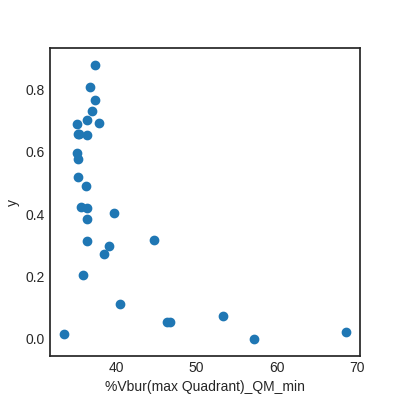

In [9]:
# import graphviz 

dt = DecisionTreeRegressor(max_depth=1).fit(X, y)
print("Accuracy: {:.2f}".format(dt.score(X, y)))

feat = int(np.where(dt.feature_importances_ != 0)[0])
print(X_labels[feat],X_names[feat])

plt.figure(figsize=(4, 4))
plt.scatter(X[:,feat], y)    
plt.xlabel(X_names[feat])
plt.ylabel("y")

# dot_data = tree.export_graphviz(dt, out_file=None, 
#                      feature_names=X_names,   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph  
plt.show()

### Classify highest and lowest group

<IPython.core.display.Javascript object>


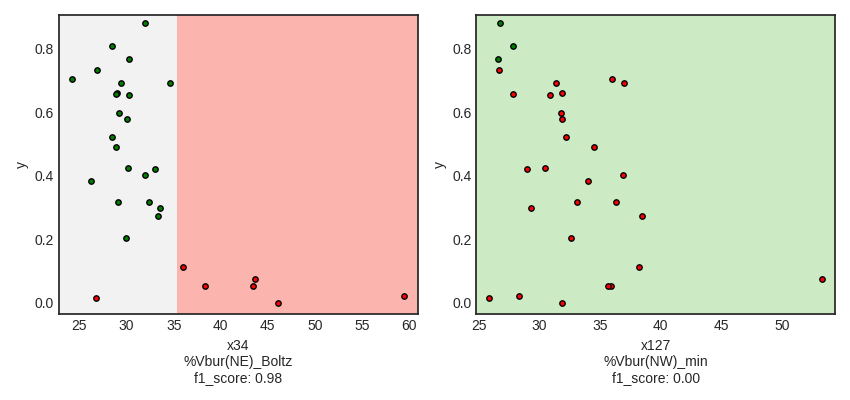

x34 %Vbur(NE)_Boltz
x127 %Vbur(NW)_min


In [10]:
# find features that separate the group with highest/lowest output y
# change the definition of bins in the histogram to get control over how these groups are defined
y_hist,y_bin_edges = np.histogram(y,bins="auto")
y_class_low = [0 if i < y_bin_edges[1] else 1 for i in y]
y_class_high = [1 if i > y_bin_edges[-2] else 0 for i in y]

plt.figure(figsize=(8.5, 4))
n_classes = 2
plot_colors = "rg"
plot_step = 0.02
y_classes = [np.asarray(y_class_low),np.asarray(y_class_high)]
for y_class,i in zip(y_classes,[1,2]):
    dt = DecisionTreeClassifier(max_depth=1).fit(X, y_class)
    feat = int(np.where(dt.feature_importances_ != 0)[0])    
    a = ("f1_score: {:.2f}".format(metrics.f1_score(y_class,dt.predict(X))))
#    b = ("auc: {:.2f}".format(metrics.roc_auc_score(y_class,dt.predict(X))))
    print(X_labels[feat],X_names[feat])    
    xpltlabel = X_labels[feat] + "\n" + X_names[feat] + "\n" + a# + "\n" + b

    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
    x_min, x_max = X[:, feat].min(), X[:, feat].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.subplot(1,2,i)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)

    plt.xlabel(xpltlabel)
    plt.ylabel("y")

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.tight_layout()

# dot_data = tree.export_graphviz(dt_plt, out_file=None, 
#                      feature_names=[x_names[feat]],   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph

### Classification

x131 %Vbur(max Quadrant)_min
Decision threshold = 35.55
Accuracy: 0.87
f1_score: 0.85
N = 30


<IPython.core.display.Javascript object>


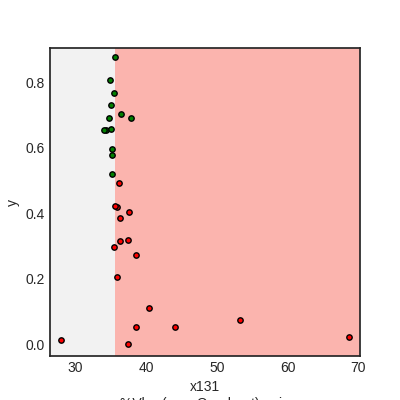

In [11]:
# divide samples into two classes based on y_cut, find the feature that most clearly distinguishes these groups
y_cut = 0.5

#this can be done on a subset of features
# features = [i for i in itertools.chain(range(75,85),range(90,95))]
# features = [i for i in range(38,135)]
features = range(np.shape(X)[1])
X_use = X[:,features]

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes=2
dt = DecisionTreeClassifier(max_depth=1).fit(X_use, y_class)

feat = features[int(np.where(dt.feature_importances_ != 0)[0])]
print(X_labels[feat],X_names[feat])

dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt_plt.tree_.threshold[0],
        dt_plt.score(X[:,feat].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt_plt.predict(X[:,feat].reshape(-1, 1))),
        len(y)
    ))

plot_colors = "rg"
plot_step = 0.02
x_min, x_max = X[:,feat].min(), X[:,feat].max()
y_min, y_max = y.min(), y.max()
dx,dy = x_max-x_min,y_max-y_min
xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                     np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))

plt.figure(figsize=(4, 4))    
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
xpltlabel = X_labels[feat] + "\n" + X_names[feat]

plt.xlabel(xpltlabel)
plt.ylabel("y")

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_class == i)
    plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    

plt.show()

### Property threshold

In [12]:
# divide samples into two classes based on y_cut, visualize how features separate these classes
y_cut = 0.5

#select features here
features = range(len(X_labels))   # iterate over all features
#features = itertools.chain(range(0,46))

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes = 2
plot_colors = "rg"
plot_step = 0.02

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    dt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)   
    print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt.tree_.threshold[0],
        dt.score(X[:,f_ind].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),
        len(y)
    ))
    
    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)
    x_min, x_max = X[:,f_ind].min(), X[:,f_ind].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.figure(figsize=(4, 4))    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
    xpltlabel = X_labels[f_ind] + "\n" + X_names[f_ind]

    plt.xlabel(xpltlabel)
    plt.ylabel("y")

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, f_ind], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    
    
    plt.show()

    



x1 Dipole_Boltz
Decision threshold = 4.12
Accuracy: 0.83
f1_score: 0.76
N = 30


<IPython.core.display.Javascript object>

x2 EFG_Amplitude_Boltz
Decision threshold = -0.23
Accuracy: 0.60
f1_score: 0.68
N = 30


<IPython.core.display.Javascript object>

x3 EFG_XX_Boltz
Decision threshold = -0.08
Accuracy: 0.63
f1_score: 0.70
N = 30


<IPython.core.display.Javascript object>

x4 EFG_YY_Boltz
Decision threshold = 0.29
Accuracy: 0.77
f1_score: 0.79
N = 30


<IPython.core.display.Javascript object>

x5 EFG_ZZ_Boltz
Decision threshold = 0.36
Accuracy: 0.70
f1_score: 0.74
N = 30


<IPython.core.display.Javascript object>

x6 fukui+_Boltz
Decision threshold = 0.07
Accuracy: 0.70
f1_score: 0.69
N = 30


<IPython.core.display.Javascript object>

x7 fukui-_Boltz
Decision threshold = 0.02
Accuracy: 0.80
f1_score: 0.80
N = 30


<IPython.core.display.Javascript object>

x8 EHOMO_Boltz
Decision threshold = -0.34
Accuracy: 0.67
f1_score: 0.72
N = 30


<IPython.core.display.Javascript object>

x9 ELUMO_Boltz
Decision threshold = 0.00
Accuracy: 0.73
f1_score: 0.76
N = 30


<IPython.core.display.Javascript object>

x10 mu_Boltz
Decision threshold = -0.14
Accuracy: 0.57
f1_score: 0.00
N = 30


<IPython.core.display.Javascript object>

x11 eta_Boltz
Decision threshold = 0.34
Accuracy: 0.73
f1_score: 0.76
N = 30


<IPython.core.display.Javascript object>

x12 omega_Boltz
Decision threshold = 0.03
Accuracy: 0.73
f1_score: 0.76
N = 30


<IPython.core.display.Javascript object>

x13 EP_O_Boltz
Decision threshold = -1.00
Accuracy: 0.67
f1_score: 0.38
N = 30


<IPython.core.display.Javascript object>

x14 natural_charge_P_Boltz
Decision threshold = 1.99
Accuracy: 0.80
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x15  EP_Cantibonds_avg_Boltz
Decision threshold = 0.26
Accuracy: 0.83
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x16  EP_Cbonds_avg_Boltz
Decision threshold = -0.63
Accuracy: 0.80
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x17 E_Prydberg_min_Boltz
Decision threshold = 1.09
Accuracy: 0.77
f1_score: 0.74
N = 30


<IPython.core.display.Javascript object>

x18 percent_s_charP_Boltz
Decision threshold = 28.25
Accuracy: 0.80
f1_score: 0.79
N = 30


<IPython.core.display.Javascript object>

x19 Hirshfeld_dipole_P_Boltz
Decision threshold = 0.03
Accuracy: 0.60
f1_score: 0.68
N = 30


<IPython.core.display.Javascript object>

x20 Hirshfeld_chargeP_Boltz
Decision threshold = 0.37
Accuracy: 0.60
f1_score: 0.67
N = 30


<IPython.core.display.Javascript object>

x21 CM5_chargeP_Boltz
Decision threshold = 0.24
Accuracy: 0.73
f1_score: 0.75
N = 30


<IPython.core.display.Javascript object>

x22 P_Isotropic_Shift_Boltz
Decision threshold = 281.25
Accuracy: 0.80
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x23 P_Anisotropic_Eigenval_XX_Boltz
Decision threshold = 198.05
Accuracy: 0.67
f1_score: 0.72
N = 30


<IPython.core.display.Javascript object>

x24 P_Anisotropic_Eigenval_YY_Boltz
Decision threshold = 211.57
Accuracy: 0.77
f1_score: 0.79
N = 30


<IPython.core.display.Javascript object>

x25 P_Anisotropic_Eigenval_ZZ_Boltz
Decision threshold = 426.78
Accuracy: 0.83
f1_score: 0.84
N = 30


<IPython.core.display.Javascript object>

x26 Polarizability_Boltz
Decision threshold = 344.19
Accuracy: 0.63
f1_score: 0.27
N = 30


<IPython.core.display.Javascript object>

x27 Amplitude_Boltz
Decision threshold = 5.20
Accuracy: 0.73
f1_score: 0.73
N = 30


<IPython.core.display.Javascript object>

x28 EigXX_Boltz
Decision threshold = 2.04
Accuracy: 0.73
f1_score: 0.71
N = 30


<IPython.core.display.Javascript object>

x29 EigYY_Boltz
Decision threshold = -11.30
Accuracy: 0.70
f1_score: 0.47
N = 30


<IPython.core.display.Javascript object>

x30 EigZZ_Boltz
Decision threshold = 15.23
Accuracy: 0.70
f1_score: 0.47
N = 30


<IPython.core.display.Javascript object>

x31 %Vbur_Boltz
Decision threshold = 33.01
Accuracy: 0.83
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x32 %Vbur(SW)_Boltz
Decision threshold = 34.21
Accuracy: 0.77
f1_score: 0.70
N = 30


<IPython.core.display.Javascript object>

x33 %Vbur(NW)_Boltz
Decision threshold = 37.83
Accuracy: 0.67
f1_score: 0.72
N = 30


<IPython.core.display.Javascript object>

x34 %Vbur(NE)_Boltz
Decision threshold = 32.17
Accuracy: 0.73
f1_score: 0.75
N = 30


<IPython.core.display.Javascript object>

x35 %Vbur(SE)_Boltz
Decision threshold = 32.02
Accuracy: 0.80
f1_score: 0.80
N = 30


<IPython.core.display.Javascript object>

x36 %Vbur(min Quadrant)_Boltz
Decision threshold = 28.83
Accuracy: 0.73
f1_score: 0.73
N = 30


<IPython.core.display.Javascript object>

x37 %Vbur(max Quadrant)_Boltz
Decision threshold = 38.18
Accuracy: 0.80
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x38 (max-min Quadrant)/%Vbur(total)_Boltz
Decision threshold = 0.22
Accuracy: 0.67
f1_score: 0.55
N = 30


<IPython.core.display.Javascript object>

x39 L_Boltz
Decision threshold = 7.04
Accuracy: 0.67
f1_score: 0.72
N = 30


<IPython.core.display.Javascript object>

x40 B1_Boltz
Decision threshold = 3.24
Accuracy: 0.67
f1_score: 0.38
N = 30


<IPython.core.display.Javascript object>

x41 B5_Boltz
Decision threshold = 6.30
Accuracy: 0.63
f1_score: 0.70
N = 30


<IPython.core.display.Javascript object>

x42 BuriedB1_Boltz
Decision threshold = 3.19
Accuracy: 0.67
f1_score: 0.38
N = 30


<IPython.core.display.Javascript object>

x43 BuriedB5_Boltz
Decision threshold = 5.93
Accuracy: 0.63
f1_score: 0.70
N = 30


<IPython.core.display.Javascript object>

x44 vmin_Boltz
Decision threshold = -0.07
Accuracy: 0.77
f1_score: 0.79
N = 30


<IPython.core.display.Javascript object>

x45 rmin_Boltz
Decision threshold = 1.79
Accuracy: 0.73
f1_score: 0.75
N = 30


<IPython.core.display.Javascript object>

x46 ECA_Boltz
Decision threshold = 143.02
Accuracy: 0.80
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x47 G_Pd_Boltz
Decision threshold = 19.36
Accuracy: 0.57
f1_score: 0.00
N = 30


<IPython.core.display.Javascript object>

x48 Dipole_QM_min
Decision threshold = 4.16
Accuracy: 0.73
f1_score: 0.56
N = 30


<IPython.core.display.Javascript object>

x49 EFG_Amplitude_QM_min
Decision threshold = -0.14
Accuracy: 0.60
f1_score: 0.68
N = 30


<IPython.core.display.Javascript object>

x50 EFG_XX_QM_min
Decision threshold = -0.07
Accuracy: 0.60
f1_score: 0.68
N = 30


<IPython.core.display.Javascript object>

x51 EFG_YY_QM_min
Decision threshold = 0.29
Accuracy: 0.77
f1_score: 0.79
N = 30


<IPython.core.display.Javascript object>

x52 EFG_ZZ_QM_min
Decision threshold = 0.35
Accuracy: 0.70
f1_score: 0.74
N = 30


<IPython.core.display.Javascript object>

x53 fukui+_QM_min
Decision threshold = 0.07
Accuracy: 0.73
f1_score: 0.71
N = 30


<IPython.core.display.Javascript object>

x54 fukui-_QM_min
Decision threshold = 0.01
Accuracy: 0.83
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x55 EHOMO_QM_min
Decision threshold = -0.34
Accuracy: 0.67
f1_score: 0.72
N = 30


<IPython.core.display.Javascript object>

x56 ELUMO_QM_min
Decision threshold = 0.00
Accuracy: 0.73
f1_score: 0.76
N = 30


<IPython.core.display.Javascript object>

x57 mu_QM_min
Decision threshold = -0.17
Accuracy: 0.63
f1_score: 0.67
N = 30


<IPython.core.display.Javascript object>

x58 eta_QM_min
Decision threshold = 0.34
Accuracy: 0.73
f1_score: 0.76
N = 30


<IPython.core.display.Javascript object>

x59 omega_QM_min
Decision threshold = 0.03
Accuracy: 0.73
f1_score: 0.76
N = 30


<IPython.core.display.Javascript object>

x60 EP_O_QM_min
Decision threshold = -1.00
Accuracy: 0.67
f1_score: 0.38
N = 30


<IPython.core.display.Javascript object>

x61 natural_charge_P_QM_min
Decision threshold = 1.99
Accuracy: 0.77
f1_score: 0.77
N = 30


<IPython.core.display.Javascript object>

x62  EP_Cantibonds_avg_QM_min
Decision threshold = 0.26
Accuracy: 0.83
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x63  EP_Cbonds_avg_QM_min
Decision threshold = -0.63
Accuracy: 0.80
f1_score: 0.81
N = 30


<IPython.core.display.Javascript object>

x64 E_Prydberg_min_QM_min
Decision threshold = 1.08
Accuracy: 0.70
f1_score: 0.69
N = 30


<IPython.core.display.Javascript object>

x65 percent_s_charP_QM_min
Decision threshold = 28.13
Accuracy: 0.77
f1_score: 0.77
N = 30


<IPython.core.display.Javascript object>

x66 Hirshfeld_dipole_P_QM_min
Decision threshold = -0.03
Accuracy: 0.70
f1_score: 0.64
N = 30


<IPython.core.display.Javascript object>

x67 Hirshfeld_chargeP_QM_min
Decision threshold = 0.36
Accuracy: 0.63
f1_score: 0.67
N = 30


<IPython.core.display.Javascript object>

TypeError: Input z must be at least a 2x2 array.

# Data preparation: Training/Test set split, Scaling

## Optional preparations

In [13]:
# perform transformations on y
y_orig = y.copy() # this is a backup of y

# y = np.exp(y_orig)

#log-transformation: either remove all samples with y=0 () or add a small amount to y to avoid log(0).
#y = np.log(y+0.01)
y = np.log(y) #Use only if no 0% yield
#or
#y = np.log(y[y.nonzero()[0]])
#y_labels_orig,X_orig = y_labels.copy(),X.copy()
#y_labels = y_labels[y.nonzero()[0]]
#X = X[y.nonzero()[0]]

# y = abs(y)

In [14]:
# remove samples based on a feature-value
# comment-out first line in Train/test split if using this
select_feature = "x78"

# define cutoff 
mask_prop = X[:,X_labels.index(select_feature)]<80

X_sel,y_sel,y_labels_sel = X[mask_prop],y_cond[:,0][mask_prop],y_labels[mask_prop]
print("Shape X: {}".format(X_sel.shape))
print("Shape y: {}".format(y_sel.shape)) 
print("Shape labels: {}".format(y_labels_sel.shape)) 

NameError: name 'y_cond' is not defined

In [ ]:
# remove samples based on index (0-indexed)
# comment-out first line in Train/test split if using this

exclude = [2,24,29]
#exclude = [16,18,19,23,24,25]+[i for i in range(26,37)]
print(exclude)
mask = [i for i in range(len(y)) if i not in exclude]
X_sel,y_sel,y_labels_sel = X[mask],y[mask],y_labels[mask]
print(y_sel)
print(y_labels_sel)

## Training/Test set split

TS: [0, 2, 4, 5, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28]
VS: [1, 3, 9, 11, 14, 27, 29]
y_mean TS: -inf
y_mean VS: -2.182
Shape X_train: (23, 188)
Shape X_test:  (7, 188)


<IPython.core.display.Javascript object>


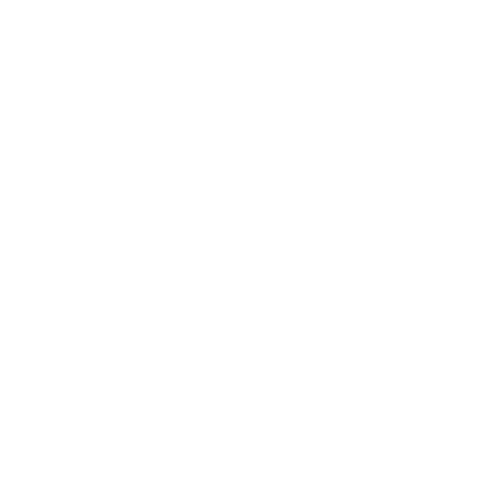

ValueError: autodetected range of [-inf, -0.12939051666985454] is not finite

In [15]:
# comment this line out if preselection was performed
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
# random
# y_equidist - picks points that evenly span the output variable y. 
#              Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section
# ks - Kennard Stone algorithm picks points based on an even distriution in feature space
# define - give a list of sample indices for either VS or TS in the corresponding code section 
# none - all samples in TS

# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

split = "y_equidist"#random"
test_ratio = 0.25

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
    # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    #TS = [16,27,25,5,13,9,29,7]
    TS = []
    VS = [16,27,25,5,13,9,29,7]
    #TS = [i-1 for i in VS] # this can be commented out if 0-indexed numbers were defined above
    #VS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]
    TS = [i for i in range(X.syhape[0]) if i not in VS and i not in exclude]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_,TS_ = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*np.shape(y_ks)[0]))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_])
        
    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]

    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Feature Scaling 

In [11]:
# scale features by mean/variance, pick the relevant option (normally: StandardScaler)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

## Cross-terms/Interaction terms

In [ ]:
# Add polynomial features/interaction terms
# this is not yet implemented properly in some sections. 
# for 5.1-manual selection: specify cross-term with space between the components: x1 x40 + x6
# Essentially only section 5.2 can use cross-terms so far
# don't run this twice

polyfeats = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
X_train_p = polyfeats.fit_transform(X_train_sc)
X_test_p = polyfeats.transform(X_test_sc)
X_all_p = polyfeats.transform(X_all_sc)

def add_to_x(matchobj):
    if "^" in matchobj.group(0):
        n = int(matchobj.group(0).split("^")[0])+1
        return("{} x{}".format(n,n))
    else:
        return(str(int(matchobj.group(0))+1))
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])



In [ ]:
# filter out non-significant crossterms based on p-value with target variable
p_val_cutoff = 0.005

r2s = []
pvals = []
for f_ind,feature in enumerate(X_train_p.T):
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, y_train)    
    r2s.append(r_value**2)
    pvals.append(p_value)
    
r2s_ = np.asarray(r2s)
pvals_ = np.asarray(pvals)

keep_p_ = [i[0] for i in np.argwhere(pvals_<p_val_cutoff) if i not in range(np.shape(X_all)[1])]
keep_p = [i for i in range(np.shape(X_all)[1])] + keep_p_

def sub_label_to_name(matchobj):
    return(X_labelname_dict[matchobj.group(0)])
def sub_labelname(matchobj):
    return(matchobj.group(0)+" "+X_labelname_dict[matchobj.group(0)])
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])
X_p_labels = list(np.reshape(pfnames[keep_p],len(keep_p)))
X_p_names = [re.sub("x[0-9]+",sub_label_to_name,st) for st in X_p_labels]
X_p_labelname = [re.sub("x[0-9]+",sub_labelname,st) for st in X_p_labels]

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train_p[:,keep_p])
X_test_sc = scaler.transform(X_test_p[:,keep_p])
X_all_sc = scaler.transform(X_all_p[:,keep_p])

X_labels = X_p_labels
X_names = X_p_names
X_labelname = X_p_labelname

print("{} cross-terms with p-value < {}".format(len(keep_p_),p_val_cutoff))

# Linear modelling, feature selection

## Manual selection of features

In [12]:
#provide an x__ model (string, any order of terms)
features_x = "x2+x20+x31"
features_py = [X_labels.index(i.strip()) for i in features_x.split("+")]

# features_py = []
#features = [int(i[1:]) for i in re.findall("x\d+",features_x)]
#features_py = [i-1 for i in features]


X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
#lr = Ridge(alpha=1E-5).fit(X_train_sel, y_train)
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train,lr)
kfoldscores = cross_val_score(lr,X_train_sel,y_train,cv=RepeatedKFold(n_splits=4, n_repeats=50))
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
#print(" + ".join([X_labelname[i] for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print("\nTraining R2;Training Q2;Test R2;{:.3f};{:.3f};{:.3f}".format(
    lr.score(X_train_sel, y_train),q2,lr.score(X_test_sel, y_test)))
print("Training K-fold R2: {:.2f} (+/- {:.2f})".format(kfoldscores.mean(), kfoldscores.std() * 2))
print("Training MAE;Test MAE;{:.2f};{:.2f}".format(metrics.mean_absolute_error(y_train,y_pred_train),metrics.mean_absolute_error(y_test,y_pred_test)))

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
#plot_gsk_poster_manual(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=True,label="% yield",loo_pred=[])
# keepmodels.append(features_py)
# keepmodels_[lr] = features_py

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [13]:
# add all individual features to the manual model
add_df = pd.DataFrame(index=X_labelname,columns=["label_sep","label_abs","Training R2","Training Q2"],dtype=float)

update_model = False
for f_ind in range(len(X_labels)):
    features_iter = features_py + [f_ind]    
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    add_df.iloc[f_ind,:] = [X_labels[f_ind],"x"+str(f_ind+1),lr.score(X_train_sel, y_train),q2]

if update_model and X_labelname.index(add_df['Training Q2'].idxmax()) not in features_py:
    features_py.append(X_labelname.index(add_df['Training Q2'].idxmax()))
add_df.sort_values(by=['Training Q2'],ascending=False).head(10)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# remove each individual feature from the manual model
print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))

rem_df = pd.DataFrame(index=[X_labelname[i] for i in features_py],
                      columns=["Training R2","Training Q2"])
for f_ind in features_py:
    features_iter = [i for i in features_py if i != f_ind]
#     print(feature, x_names[f_ind])
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    rem_df.loc[X_labelname[f_ind],:] = [lr.score(X_train_sel, y_train),q2]

rem_df.sort_values(by=['Training Q2'],ascending=False)

## Forward stepwise selection based on p-values

Add                              45 with p-value 0.000158828
Add                               1 with p-value 0.000241953
Add                              24 with p-value 0.0102618
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     29.75
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           2.19e-07
Time:                        05:11:36   Log-Likelihood:                 17.725
No. Observations:                  23   AIC:                            -27.45
Df Residuals:                      19   BIC:                            -22.91
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std 

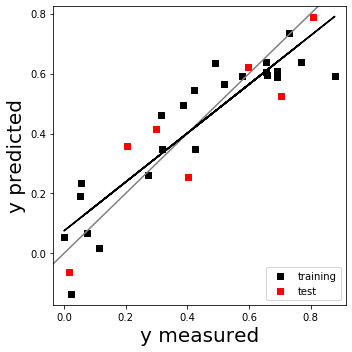

In [8]:
# Forward stepwise selection based on p-value
# threshold values refer to p-value of individual features
threshold_in = 0.05
threshold_out = 0.075 # must be larger than threshold_in

use_manual_feats = False # if True, model from previous section will be used as starting point

import stepwise_selection2 as step_s
if not use_manual_feats:
    features_py=[]

selected_feats = step_s.stepwise_selection(pd.DataFrame(X_train_sc), y_train,
                    initial_list=features_py,threshold_in=threshold_in,threshold_out=threshold_out,verbose=True)

print("\n"+" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_labelname[i] for i in sorted(selected_feats)]))

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
#lr = Ridge(alpha=1E-6).fit(X_train_sel, y_train)
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train,lr)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
    lr.score(X_train_sel, y_train),q2,lr.score(X_test_sel, y_test)))

plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
#keepmodels.append(selected_feats)

## other forward feature selection implementations

In [ ]:
#Scikit-learn - forward feature selection
# largely useless
# options for criteria: 
# mutual_info_regression, f_regression
# select number of features with k

criteria = f_regression
skb = SelectKBest(criteria,k=4).fit(X_train_sc,y_train)
selected_feats = skb.get_support(indices=True)
print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = skb.transform(X_train_sc)
X_test_sel = skb.transform(X_test_sc)
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train,lr)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,lr.score(X_test_sel, y_test)))

plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

In [ ]:
# Forward stepwise selection based on AIC ("aic") or Q2 ("q2")
criteria = "aic"

import forwardselect_q5 as fsq

df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))

newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
a,b = fsq.Forward_Select(df,"y","Regression",criteria)
selected_feats = [int(i[1:]) for i in b]
print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([x_names[i] for i in sorted(selected_feats)]))

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train,lr)
print("\n\n")
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))

plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

## Forward stepwise selection keeping a set of candidates at each step

### Model search

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 13.4651
Step 3
Step 4
Done. Time taken (minutes): 1.00


Best model:
1 + x17 + x23 + x37
1 + E_Prydberg_min + P_Anisotropic_Eigenval_XX + %Vbur(max Quadrant)

Training R2;Training Q2;Test R2;0.64;0.52;0.55


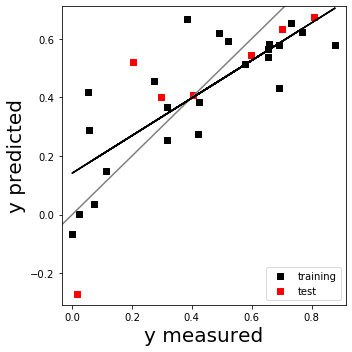

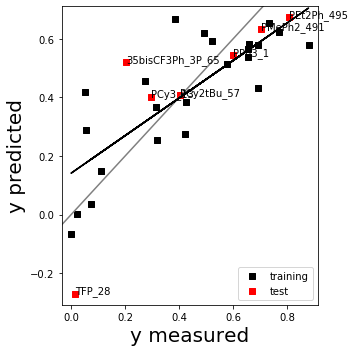

In [9]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 4
n_candidates = 50
collin_criteria = 0.3 # this is R2
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2b as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = candidates[0]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print("\n\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
q2,loo_train = loo.q2(X_train_sel,y_train,lr)
# print("\n\n")
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
    lr.score(X_train_sel, y_train),q2,lr.score(X_test_sel, y_test)))
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
plot_fit_label(y_train,y_pred_train,y_test,y_pred_test)

#Add sorting to results DF - second revision will alter the ForwardStepCandidates_2b itself to include options
#prioritize validation R2 over Q2 + include K-fold

scores_r2_test = []
k_fold = []

for model in sortedmodels:
    X_sel = list(model)
    X_sel_i = [X_labels.index(i.strip()) for i in X_sel]
    X_train_sel = X_train_sc[:,X_sel_i]
    X_test_sel = X_test_sc[:,X_sel_i]
    lr = LinearRegression().fit(X_train_sel,y_train)
    #kfoldscores = cross_val_score(lr,X_train_sel,y_train,cv=RepeatedKFold(n_splits=4, n_repeats=50))
    #k_fold.append(kfoldscores)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test = lr.predict(X_test_sel)
    model_test_r2_score = lr.score(X_test_sel,y_test)
    scores_r2_test.append(model_test_r2_score)
        
test_r2_df = pd.DataFrame(scores_r2_test, columns=['Test R^2'])
#k_fold_df = pd.DataFrame(k_fold,columns=['K Fold'])
#results = pd.concat([results,test_r2_df,k_fold_df])
results = pd.concat([results,test_r2_df],axis=1)

# selected_feats = [x_labels.index(i) for i in models[candidates[0]].terms]
# X_train_sel = X_train_sc[:,selected_feats]
# X_test_sel = X_test_sc[:,selected_feats]
# y_pred_train = models[candidates[0]].model.predict(X_train_sel)
# y_pred_test =  models[candidates[0]].model.predict(X_test_sel)
# print("\nBest model:")
# print(models[candidates[0]].formula)
# print("1 + "+" + ".join([x_names[x_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
# print("R^2 = {:.2f}".format(models[candidates[0]].r2))
# print("Q^2 = {:.2f}".format(models[candidates[0]].q2))
# print("R^2_test = {:.2f}".format(models[candidates[0]].model.score(X_test_sel, y_test)))
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
# models[candidates[0]].r2,models[candidates[0]].q2,metrics.r2_score(y_pred_test,y_test)))

# plot_fit(y_train,y_pred_train,y_test,y_pred_test)


In [ ]:
#View only well validated models (criteria = test R2 must be within 0.3 of training R2, Q2 within 0.1 of training R2)
results['diff_R2'] = results['R^2']-results['Test R^2']
results['diff_Q2'] = results['R^2']-results['Q^2']

validatedmodels = results[results.diff_R2<0.3][results.diff_Q2<0.1].sort_values(by=['diff_R2','diff_Q2'],ascending=True)

#Evaluate k-fold of these well validated models - convert back to numpy arrays and then use scikit learn metrics?
#Then sort based on k_fold and test R

kfold = []

for model in validatedmodels['Model'].tolist():
    params_used = [X_labels.index(i) for i in models[model].terms]
    X_train_sel = X_train_sc[:,params_used]
    X_test_sel = X_test_sc[:,params_used]
    lr = LinearRegression().fit(X_train_sel, y_train)
    kfoldscores = cross_val_score(lr,X_train_sel,y_train,cv=RepeatedKFold(n_splits=4, n_repeats=50))
    kfold_avg = np.mean(kfoldscores)
    kfold.append(kfold_avg)
    
kfold_df = pd.DataFrame(kfold,columns=['K Fold'],index=validatedmodels.index.values)
validatedmodels_kfold = pd.concat([validatedmodels,kfold_df],axis=1)

#Save CSV - v2 will involve an ipywidget to give more obvious control over filename
validatedmodels_kfold.to_csv(excel_file + '_' + excel_sheet + '_modelssorted.csv')
validatedmodels_kfold.sort_values(by=['K Fold'],ascending=False).head(25)

### View models as list

In [10]:
# view best models
results.sort_values(by=['Q^2'],ascending=False).head(25)
#results.sort_values(by=['Test R^2','Q^2'],ascending=False).head(25)

Model  n_terms       R^2       Q^2  Test R^2
0    (x15, x2, x25, x46)        4  0.845710  0.732327  0.531767
1    (x2, x20, x23, x31)        4  0.808744  0.728019  0.737149
2   (x13, x18, x25, x37)        4  0.816532  0.721839 -0.133706
3    (x19, x2, x20, x46)        4  0.786798  0.721455  0.720113
4   (x12, x20, x25, x37)        4  0.815318  0.718777 -0.258011
5    (x19, x2, x40, x46)        4  0.786654  0.716685  0.563362
6    (x2, x23, x42, x46)        4  0.814627  0.716272  0.542198
7         (x2, x20, x31)        3  0.765507  0.710545  0.695644
8     (x2, x20, x34, x6)        4  0.801755  0.707460  0.188412
9    (x2, x20, x23, x46)        4  0.794775  0.705471  0.896299
10        (x2, x20, x46)        3  0.767357  0.704996  0.737284
11   (x2, x25, x40, x46)        4  0.829515  0.704952  0.750071
12        (x19, x2, x46)        3  0.775794  0.704537  0.623556
13   (x19, x2, x42, x46)        4  0.784912  0.703637  0.549155
14   (x2, x20, x25, x46)        4  0.841219  0.702586  0.783185
15        (x2, x25, x46)        3  0.824499  0.701660  0.790559
16   (x19, x2, x29, x46)        4  0.780029  0.699584  0.639288
17    (x2, x20, x31, x6)        4  0.807947  0.699155  0.516306
18   (x19, x2, x30, x46)        4  0.779376  0.698999  0.641118
19        (x2, x40, x46)        3  0.768524  0.698924  0.574195
20        (x2, x42, x46)        3  0.770078  0.698877  0.511307
21   (x19, x2, x41, x46)        4  0.779156  0.698748  0.614298
22   (x2, x20, x22, x46)        4  0.827407  0.698566  0.777436
23   (x19, x2, x45, x46)        4  0.780256  0.697671  0.322758
24   (x2, x20, x40, x46)        4  0.773255  0.696453  0.662941

### Filter results

In [ ]:
# view models with a specific number of terms
selmods = results[results.n_terms <=3].sort_values(by=['Q^2'],ascending=False)
selmods.head(25)

In [ ]:
# example for filtering results
#selmods2 = results.loc[[i for i in results.index if "x113" in results.loc[i,"Model"] and "x49" not in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
selmods2 = results.loc[[i for i in results.index if "x140" in results.loc[i,"Model"] ]][results.n_terms < 4].sort_values(by=['Q^2'],ascending=False)
selmods2

In [ ]:
# filter models that contain more than one term that is also in a reference model
reference_model = 0 # this number refer to the index in 'results' or 'selmods', whichever is used 
use_df = results # or: selmods

uniquemods = {use_df.loc[reference_model,"Model"]:reference_model}
for ind in use_df.index:
    selmod = use_df.loc[ind,"Model"]
    if len(selmod) <= 2:
        continue
        
    add = True
    for mod in uniquemods.keys():
        if len([i for i in mod if i in selmod]) >= 2:
            add = False
            break
    if add:      
        uniquemods[use_df.loc[ind,"Model"]] = ind
    
    
print(len(uniquemods.keys()))
selmods2 = results.loc[uniquemods.values()]
selmods2

### Visualize models

1 + x2 + x20 + x23 + x31
1 + EFG_Amplitude + Hirshfeld_chargeP + P_Anisotropic_Eigenval_XX + %Vbur

Features: x2 + x20 + x23 + x31

Parameters:
    0.4145 + 
    0.1340 * x2 EFG_Amplitude
   -0.0607 * x20 Hirshfeld_chargeP
   -0.0688 * x23 P_Anisotropic_Eigenval_XX
   -0.1592 * x31 %Vbur

Training R2;Training Q2;Test R2;0.806;0.728;0.735
Training K-fold R2: 0.49 (+/- 1.29)
Training MAE;Test MAE;0.09;0.11


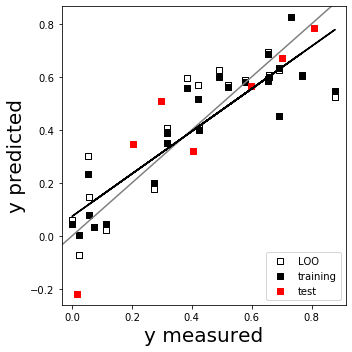

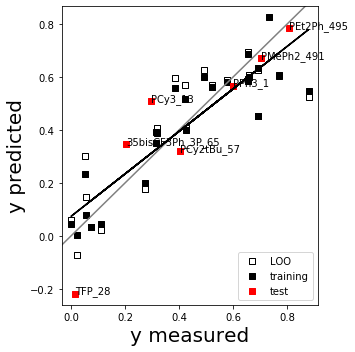

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     19.03
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           2.83e-06
Time:                        05:17:44   Log-Likelihood:                 16.737
No. Observations:                  23   AIC:                            -23.47
Df Residuals:                      18   BIC:                            -17.80
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4248      0.028     15.420      0.0

In [13]:
# visualize other models
model_sel = results.loc[1,"Model"]

#other ways of selecting models:
# model_sel = results.iloc[selmods.index[3],0]
# model_sel = results.iloc[785,0]
# model_sel = ("x100","x31")


selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
q2,loo_train = loo.q2(X_train_sel,y_train,lr)
kfoldscores = cross_val_score(lr,X_train_sel,y_train,cv=RepeatedKFold(n_splits=4, n_repeats=50))
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print("\nTraining R2;Training Q2;Test R2;{:.3f};{:.3f};{:.3f}".format(
    lr.score(X_train_sel, y_train),q2,lr.score(X_test_sel, y_test)))
print("Training K-fold R2: {:.2f} (+/- {:.2f})".format(kfoldscores.mean(), kfoldscores.std() * 2))
print("Training MAE;Test MAE;{:.2f};{:.2f}".format(metrics.mean_absolute_error(y_train,y_pred_train),metrics.mean_absolute_error(y_test,y_pred_test)))


plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=loo_train)
plot_fit_label(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=loo_train)
#plot_gsk_poster(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=True,label="% Yield",loo_pred=[])

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

### Violin Plots

In [ ]:
#Purpose: Construct violin plots to show conformational dependence of parameters included in model
#Import full parameter values, requires Excel sheet with all conformer values assuming same parameters
#Future version -- possible to highlight QM min, boltzmann parameter within violin??
excel_file_full = "OPR3_master_list_2Aug2019"
excel_sheet_full = "master_list"

model_sel = results.loc[0,"Model"]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]

inp_violin = pd.read_excel(excel_file_full+".xlsx",excel_sheet_full,header=0)

def violin_plot(feature): #Feature is the x value, will be located for the parameter/column name
    sns.set_style('ticks')
    param = 
    sns.violinplot(x=inp_violin['ligand name'],y=inp_violin[param],palette='rainbow',inner='points')
    
#Violin plot for each feature in the model!
for x in :
    violin_plot(x)























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































## Ridge Regression, no feature selection

In [ ]:
linm = Ridge().fit(X_train_sc, y_train)

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,4,9)
for parm in parm_range:
    print(parm)
    linm = Ridge(alpha=parm).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,linm)
    
    y_pred_train = linm.predict(X_train_sc)
    y_pred_test =  linm.predict(X_test_sc)
    #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(linm.score(X_train_sc, y_train),q2,linm.score(X_test_sc, y_test)))
    #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
        
    r2s.append(linm.score(X_train_sc, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
linm = Ridge(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = linm.predict(X_train_sc)
y_pred_test =  linm.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

## Lasso feature selection

In [ ]:
# Lasso feature selection

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,1,6)
for parm in parm_range:
    print(parm)
    lasso = Lasso(alpha=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(lasso.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(lasso.coef_!=0)[0]]
    try:
        q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
        lr = LinearRegression().fit(X_train_sel,y_train)
        y_pred_train = lr.predict(X_train_sel)
        y_pred_test =  lr.predict(X_test_sel)
        #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
        print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,lr.score(X_test_sel, y_test)))
        #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
    except:
        pass
    print("     Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
    # print(np.where(lr.coef_ != 0)[1])
    
    r2s.append(lasso.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
lasso = Lasso(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = lasso.predict(X_train_sc)
y_pred_test =  lasso.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    
    
# llbic = LassoLarsIC(criterion="bic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llbic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llbic.coef_!=0)[0]]
# print("\n\nLassoLarsIC bic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llbic.score(X_train_sc, y_train),q2,llbic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llbic.coef_ != 0)))

# llaic = LassoLarsIC(criterion="aic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llaic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llaic.coef_!=0)[0]]
# print("\n\nLassoLarsIC aic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llaic.score(X_train_sc, y_train),q2,llaic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llaic.coef_ != 0)))

# lassocv = LassoCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(lassocv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(lassocv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nLassoCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lassocv.score(X_train_sc, y_train),q2,lassocv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(lassocv.coef_ != 0)))
# print(np.where(lassocv.coef_ != 0)[1])

llcv = LassoLarsCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(llcv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(llcv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
print("\n\nLassoLarsCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llcv.score(X_train_sc, y_train),q2,llcv.score(X_test_sc, y_test)))
print("Number of features used: {}".format(np.sum(llcv.coef_ != 0)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = llcv.predict(X_train_sc)
y_pred_test =  llcv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    



## Elastic Net

In [ ]:
%%time
encv = ElasticNetCV(l1_ratio=[.01,.05,.66,.1,.2,.3, .5, .7, .9, .95, .99, 1],
#                     n_alphas=500,
                    alphas=np.logspace(-1,4,100),
                    cv=3,n_jobs=-1,max_iter=1000000).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(encv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(encv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,Ridge(alpha=encv.alpha_))
print("\n\nElasticNetCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(encv.score(X_train_sc, y_train),q2,encv.score(X_test_sc, y_test)))
print("Number of features used: {}".format(np.sum(encv.coef_ != 0)))
print("Best hyperparameters: l1_ratio = {}, alpha = {}".format(encv.l1_ratio_,encv.alpha_))

y_pred_train = encv.predict(X_train_sc)
y_pred_test =  encv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test) 


## Orthogonal Matching Pursuit

In [ ]:
# Orthogonal Matching Pursuit

parm_range = range(1,10)
print(np.shape(X_train_sc))
print(np.shape(y_train))
for parm in parm_range:
    print(parm)
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(omp.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(omp.coef_!=0)[0]]
    q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(omp.score(X_train_sc, y_train),q2,omp.score(X_test_sc, y_test)))

    print("     "+" + ".join(["x"+str(i+1) for i in np.where(omp.coef_ != 0)[0]]))
    #print("     Number of features used: {}".format(np.sum(lr.coef_ != 0)))
    

# ompcv = OrthogonalMatchingPursuitCV(cv=LeaveOneOut(),n_jobs=-1).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(ompcv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(ompcv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nOrthogonalMatchingPursuitCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(ompcv.score(X_train_sc, y_train),q2,ompcv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(ompcv.coef_ != 0)))

# print("\n"+" + ".join(["x"+str(i+1) for i in np.where(ompcv.coef_!=0)[0]]))
# print("\n"+" + ".join([X_names[i] for i in np.where(ompcv.coef_!=0)[0]]))

# y_pred_train = ompcv.predict(X_train_sc)
# y_pred_test =  ompcv.predict(X_test_sc)
# plot_fit(y_train,y_pred_train,y_test,y_pred_test)


# Nonlinear Modelling

## Kernel Ridge Regression 

In [ ]:
# Kernel Ridge Regression 
# kernel options: linear, poly, rbf

r2s = []
q2s = []
parms = []
print("\n\nKernelRidge")

kernel="poly"
degree=2

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm
    ).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,kr)
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        kr.score(X_train_sc, y_train),q2,kr.score(X_test_sc, y_test)))
    r2s.append(kr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = kr.predict(X_train_sc)
y_pred_test =  kr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)



## Support Vector Regression

In [ ]:
# SVR

r2s = []
q2s = []
parms = []
print("\n\nSupport Vector Regression")

kernel="poly"
degree=2
gamma="auto"

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print("{:.2E}".format(parm))
    svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=parm
    ).fit(X_train_sc, y_train)
    
    q2,loo_train = loo.q2(X_train_sc,y_train,svr)
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        svr.score(X_train_sc, y_train),q2,svr.score(X_test_sc, y_test)))
    r2s.append(svr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = svr.predict(X_train_sc)
y_pred_test =  svr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
   

# keepmodels_[svr] = ()

## Regression with Principal Components

In [ ]:
# Regression with Principal Components

for npca in range(1,9):
    pca = PCA(n_components=npca)
    pca.fit(scaler.transform(X_sel))
#     pca.fit(X_train_sc)
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)

    pca_score = pca.explained_variance_ratio_
    pca_values = pca.singular_values_
    V = pca.components_

    linr = LinearRegression().fit(X_train_pca, y_train)
#     linr = Ridge(alpha=1).fit(X_train_pca,y_train)
    q2,loo_train = loo.q2(X_train_pca,y_train,LinearRegression())
    print("\n\nPC Regression {}".format(npca))
    print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        linr.score(X_train_pca, y_train),q2,linr.score(X_test_pca, y_test)))

    y_pred_train = linr.predict(X_train_pca)
    y_pred_test =  linr.predict(X_test_pca)

    plot_fit(y_train,y_pred_train,y_test,y_pred_test)

    
# # virtual screening
# X_screen_sel = pca.transform(X_all_sc)
# y_pred_vscreen = linr.predict(X_screen_sel)
# y_vscreen["PCA5"] = y_pred_vscreen


# keepmodels_[PCA(n_components=2).fit(scaler.transform(X_sel))] = ("n_components=2")

## Random Forest

In [ ]:
%%time
# Random forest regression

rf  = RandomForestRegressor(n_estimators=500,random_state=42,n_jobs=None,max_features=None,max_depth=None).fit(
    X_train_sc, y_train)
# rf = GradientBoostingRegressor(
#     n_estimators=50,
#     subsample=.6,
#     max_depth=2,
#     random_state=42,
#     max_features=None,
#     alpha=0.9,
#     ).fit(X_train_sc, y_train)

print("Training R2;Test R2;{:.2f};{:.2f}".format(
    rf.score(X_train_sc, y_train),rf.score(X_test_sc, y_test)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = rf.predict(X_train_sc)
y_pred_test =  rf.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

# keepmodels_[rf] = ()

#  Plot options

## Standard Presentation

In [ ]:
def plot_presentation(y_train,y_pred_train,y_test,y_pred_test,model_index,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    plt.scatter(y_train,y_pred_train,label="Training Set",color="#005493",marker="o") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="Validation Set",color="grey",marker="o")     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="black",linestyle='--') #,alpha=0.2
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel("Measured " + label,fontsize=14,fontweight="bold")
    plt.ylabel("Predicted " + label,fontsize=14,fontweight="bold")
    
    #Insert model details in upper left hand corner
    model_x_val = results.loc[model_index,'Model']
    plt.text(0,0.835, 'R² = %.2f \nQ² = %.2f \nK Fold = %.2f' % (validatedmodels_kfold.loc[model_index,'R^2'],validatedmodels_kfold.loc[model_index, 'Q^2'],validatedmodels_kfold.loc[model_index,'K Fold']))
    #plt.text(0,0.835,'R² = ' + str(validatedmodels_kfold.loc[model_index,'R^2']) + '\nQ² = ' + str(validatedmodels_kfold.loc[model_index, 'Q^2'])+'\nK-fold = '+str(validatedmodels_kfold.loc[model_index,'K Fold']))
    
    #Save figure
    plt.show()
    

In [ ]:
plot_presentation(y_train,y_pred_train,y_test,y_pred_test,30,leg=True,sav=False,label="% yield",loo_pred=[])

## GSK Poster

In [ ]:
def plot_gsk_poster(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    plt.scatter(y_train,y_pred_train,label="Training Set",color="#00b6c9",marker="o") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="Validation Set",color="#be0077",marker="o")     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="grey") #,alpha=0.2
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel("Measured " + label,fontsize=14,fontweight="bold")
    plt.ylabel("Predicted " + label,fontsize=14,fontweight="bold")
    
def plot_gsk_poster_manual(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    #plt.scatter(y_train,y_pred_train,label="Training Set",color="#00b6c9",marker="o") # ,alpha=0.6
    #plt.scatter(y_test,y_pred_test,label="Validation Set",color="#be0077",marker="o")     #,alpha=0.25
    #plt.plot(y_train,yy_fit_line,color="grey") #,alpha=0.2
    plt.scatter(y_train,y_pred_train,label="Training Set",color="#005493",marker="o") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="Validation Set",color="#941100",marker="o")     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="grey") #,alpha=0.2
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel("Measured " + label,fontsize=14,fontweight="bold")
    plt.ylabel("Predicted " + label,fontsize=14,fontweight="bold")
    
#     plt.xticks([])
#     plt.yticks([])
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(excel_file+excel_sheet+features_x,dpi=300)
    
keepmodels = []